In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.api as smt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Flatten, TimeDistributed, GRU
from keras.layers.convolutional import Conv1D, MaxPooling1D


%matplotlib inline

pd.options.display.max_rows = 20

Using TensorFlow backend.


In [2]:
df = pd.read_csv('Air_Traffic_Passenger_Statistics.csv')

In [3]:
df.head()

,Activity Period,Operating Airline,Operating Airline IATA Code,Published Airline,Published Airline IATA Code,GEO Summary,GEO Region,Activity Type Code,Price Category Code,Terminal,Boarding Area,Passenger Count
0,201903,Japan Airlines,JL,Japan Airlines,JL,International,Asia,Enplaned,Other,International,A,6995
1,201903,Virgin Atlantic,VS,Virgin Atlantic,VS,International,Europe,Enplaned,Other,International,A,12172
2,201903,Virgin Atlantic,VS,Virgin Atlantic,VS,International,Europe,Deplaned,Other,International,A,11496
3,201903,United Airlines,UA,United Airlines,UA,International,Middle East,Enplaned,Other,International,G,7473
4,201903,United Airlines,UA,United Airlines,UA,International,Middle East,Deplaned,Other,International,G,6857


In [4]:
df.shape

(20256, 12)

In [5]:
# Dropping nulls that I found in columns - only a few
df.dropna(inplace = True)

In [6]:
df.columns

Index(['Activity Period', 'Operating Airline', 'Operating Airline IATA Code',
       'Published Airline', 'Published Airline IATA Code', 'GEO Summary',
       'GEO Region', 'Activity Type Code', 'Price Category Code', 'Terminal',
       'Boarding Area', 'Passenger Count'],
      dtype='object')

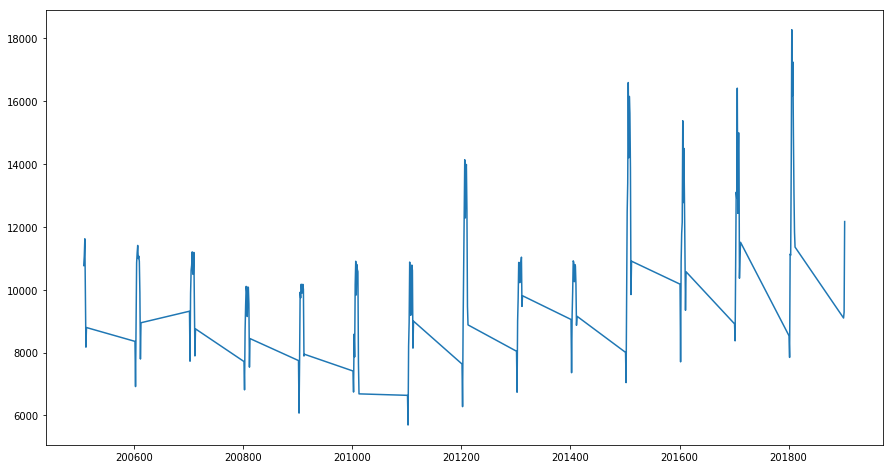

In [7]:
# Plotting one airline's flights against time to see how the time series look

df_explore_virgin = df[(df['Operating Airline'] == 'Virgin Atlantic')  & (df['Activity Type Code'] == 'Enplaned')]

# Plot of passengers leaving SFO on Virgin Atlantic
plt.figure(figsize = (15,8))
plt.plot(df_explore_virgin['Activity Period'], df_explore_virgin['Passenger Count']);

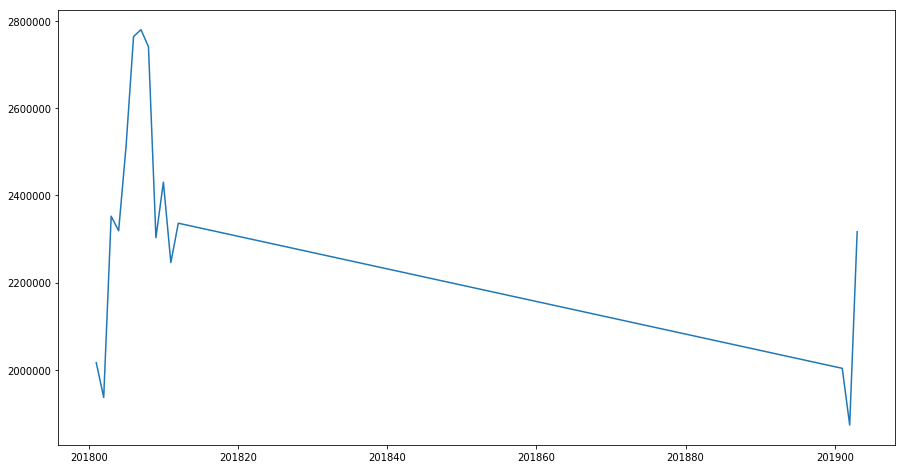

In [9]:
df_explore = df[df['Activity Type Code'] == 'Enplaned'].groupby('Activity Period').sum()

df_explore = df_explore[df_explore.index >= 201800]

# Zoomed-in version shows that it is interpreting the difference between "201812" and "201901" incorrectly
plt.figure(figsize = (15,8))
plt.plot(df_explore.index, df_explore['Passenger Count'])
#plt.savefig('img/data_cleaning_dates.png', bbox_inches = 'tight');

# Data Cleaning

In [10]:
df['date'] = pd.to_datetime(df['Activity Period'], format = '%Y%m')

In [11]:
# Eliminating rows that account for passengers in layovers. Don't care about those
df.set_index('Activity Type Code', inplace = True)
df.drop(index = 'Thru / Transit', inplace = True)

In [12]:
# Changing the index to dates so that I can use time-series unique functions like pd.resample()
df.reset_index(inplace = True)

# Dropping the no longer useful column that we derived dates from
df.drop(columns = 'Activity Period', inplace = True)

In [13]:
# Cleaning up the name of the 'United Airlines' that is pre-2013
df.replace('United Airlines - Pre 07/01/2013', 'United Airlines', inplace = True)

## Next up: I need to group by the proper types so I can get "enplaned" and "deplaned" trends, and conduct separate time series analysis on them

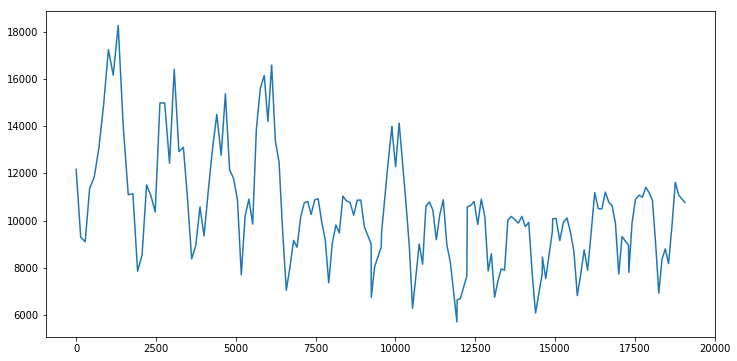

In [14]:
df_explore_virgin = df[(df['Operating Airline'] == 'Virgin Atlantic')  & (df['Activity Type Code'] == 'Enplaned')]

# Improved plot of Virgin Atlantic after datetime was fixed
plt.figure(figsize = (12,6))
plt.plot(df_explore_virgin.index, df_explore_virgin['Passenger Count']);

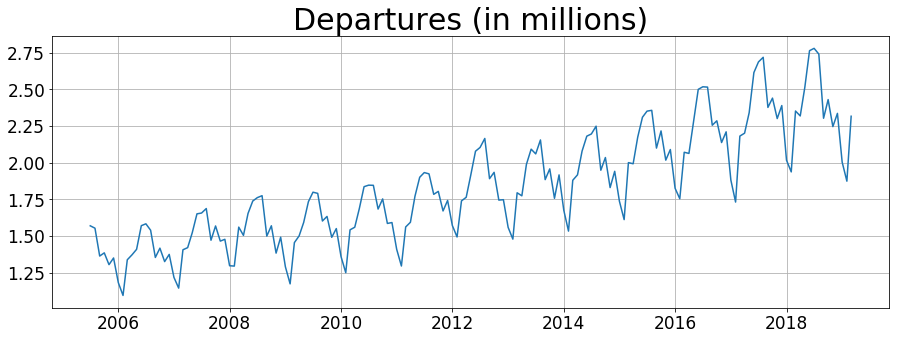

In [16]:
enplaned = df[df['Activity Type Code'] == 'Enplaned'].groupby('date').sum()

# Improved plot of total air traffic after datetime was fixed

plt.figure(figsize = (15,5))
sns.lineplot(enplaned.index, enplaned['Passenger Count'] / 1000000)
plt.title('Departures (in millions)', fontsize=30)
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.grid(b=True)
#plt.savefig('img/sfo_traffic.png', bbox_inches = 'tight')

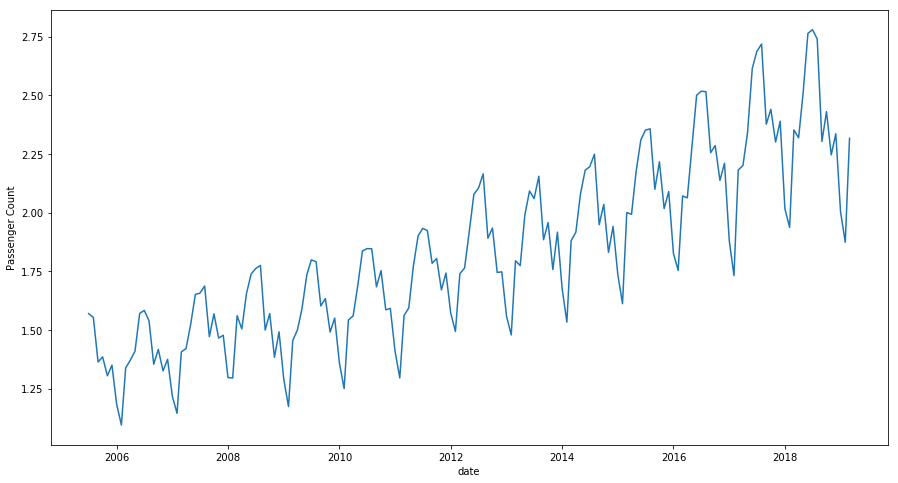

In [18]:
plt.figure(figsize = (15,8))
sns.lineplot(enplaned.index, enplaned['Passenger Count'] / 1000000)
#plt.savefig('img/cleaned_time_series.png', bbox_inches = 'tight')

## Operating Airline vs Published Airline

In [19]:
# A company like SkyWest Airline is never a Published Airline - only an Operating Airline
df.loc[df['Operating Airline'] == 'SkyWest Airlines', 'Published Airline'].unique()

array(['United Airlines', 'Alaska Airlines', 'Delta Air Lines',
       'American Airlines'], dtype=object)

In [20]:
df['Operating Airline'].value_counts()

United Airlines                     3295
SkyWest Airlines                    1292
Alaska Airlines                      820
Virgin America                       462
Delta Air Lines                      446
Air Canada                           438
American Airlines                    416
JetBlue Airways                      337
Sun Country Airlines                 335
Frontier Airlines                    332
                                    ... 
Jet Airways                           16
Allegiant Air                         16
Miami Air International               16
Air Canada Jazz                       14
Independence Air                      10
World Airways                          3
Xtra Airways                           2
Evergreen International Airlines       2
Norwegian Air UK Ltd                   2
Atlas Air, Inc                         1
Name: Operating Airline, Length: 84, dtype: int64

In [21]:
df['Published Airline'].value_counts()

United Airlines                     4182
Alaska Airlines                     1178
Delta Air Lines                      990
American Airlines                    660
Air Canada                           520
Virgin America                       462
US Airways                           407
JetBlue Airways                      337
Sun Country Airlines                 335
Frontier Airlines                    332
                                    ... 
Icelandair                            20
Allegiant Air                         16
Jet Airways                           16
Miami Air International               16
Independence Air                      10
World Airways                          3
Xtra Airways                           2
Evergreen International Airlines       2
Norwegian Air UK Ltd                   2
Atlas Air, Inc                         1
Name: Published Airline, Length: 74, dtype: int64

In [22]:
# Shows that Operating Airline is different from Published Airline ~2000 times: 1/10 of the time in my df
df[df['Operating Airline'] != df['Published Airline']]

,Activity Type Code,Operating Airline,Operating Airline IATA Code,Published Airline,Published Airline IATA Code,GEO Summary,GEO Region,Price Category Code,Terminal,Boarding Area,Passenger Count,date
39,Enplaned,SkyWest Airlines,OO,United Airlines,UA,International,Canada,Other,Terminal 3,F,3363,2019-03-01
40,Deplaned,SkyWest Airlines,OO,United Airlines,UA,International,Canada,Other,Terminal 3,F,3262,2019-03-01
41,Deplaned,SkyWest Airlines,OO,United Airlines,UA,International,Canada,Other,International,G,3191,2019-03-01
42,Enplaned,SkyWest Airlines,OO,United Airlines,UA,Domestic,US,Other,Terminal 3,F,167195,2019-03-01
43,Deplaned,SkyWest Airlines,OO,United Airlines,UA,Domestic,US,Other,Terminal 3,F,172593,2019-03-01
44,Enplaned,SkyWest Airlines,OO,Alaska Airlines,AS,Domestic,US,Other,Terminal 2,D,18534,2019-03-01
45,Deplaned,SkyWest Airlines,OO,Alaska Airlines,AS,Domestic,US,Other,Terminal 2,D,18142,2019-03-01
46,Enplaned,SkyWest Airlines,OO,Delta Air Lines,DL,Domestic,US,Other,Terminal 1,C,8263,2019-03-01
47,Deplaned,SkyWest Airlines,OO,Delta Air Lines,DL,Domestic,US,Other,Terminal 1,C,8496,2019-03-01
68,Enplaned,Jazz Aviation,QK,Air Canada,AC,International,Canada,Other,International,G,7719,2019-03-01


**I will use Operating Airlines since that indicates who is actually flying the flight. The Published Airline is the one who is marketing the flight, and Operating is the one who is actually flying it. Individuals know that the flight is being operated by SkyWest Airlines, for instance, even if they bought the ticket from United.**

In [23]:
# Autocorrelation across all airlines is very close to 1
enplaned['Passenger Count'].autocorr(lag = 12)

0.982749011896593

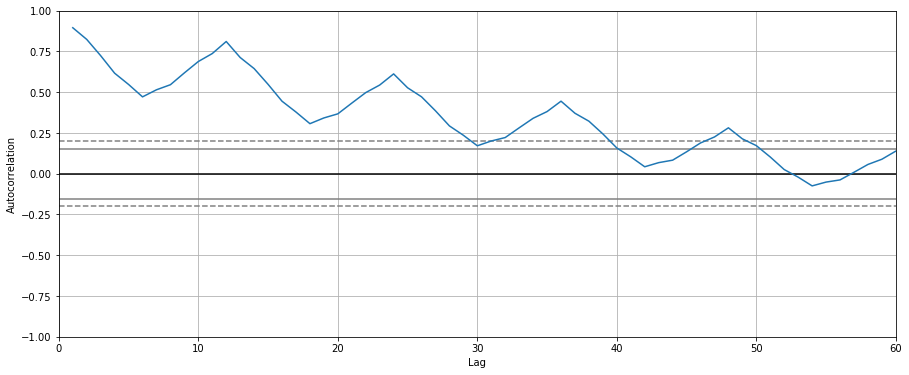

In [24]:
# We definitely have autocorrelation - peaking at the 12 month mark and the 1 month mark
plt.figure(figsize = (15,6))
pd.plotting.autocorrelation_plot(enplaned['Passenger Count'])
plt.xlim(0,60);

## Check for stationarity

Aiming for an autocorrelation that is approximately 0, and not more negative that -0.5, per https://people.duke.edu/~rnau/411arim2.htm

In [25]:
print(enplaned['Passenger Count'].autocorr())
print(enplaned['Passenger Count'].diff().autocorr()) # Autocorrelation approx == 0
print(enplaned['Passenger Count'].diff().diff().autocorr())

0.9009954328098658
-0.1271691639102012
-0.6064341398992737


In [26]:
print(enplaned.std())
print(enplaned.diff().std()) # Std is at its lowest
print(enplaned.diff().diff().std())

Passenger Count    380995.515031
dtype: float64
Passenger Count    169512.571295
dtype: float64
Passenger Count    252641.798598
dtype: float64


Both of the above tests confirm that only one layer of differencing is needed in our model

### ARIMA guides for further work, if needed:

Textbooks:

https://people.duke.edu/~rnau/seasarim.htm

http://www.statsoft.com/Textbook/Time-Series-Analysis#1general

Articles:

https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/

https://medium.com/@josemarcialportilla/using-python-and-auto-arima-to-forecast-seasonal-time-series-90877adff03c

Documentation examples:

https://www.statsmodels.org/stable/examples/notebooks/generated/statespace_sarimax_stata.html

In [ ]:
df.head()

In [ ]:
df_enplaned = df[df['Activity Type Code'] == 'Enplaned']
df_deplaned = df[df['Activity Type Code'] == 'Deplaned']

df_enplaned = df_enplaned.groupby(by = ['date', 'Operating Airline']).sum()
df_deplaned = df_deplaned.groupby(by = ['date', 'Operating Airline']).sum()

In [ ]:
df_deplaned

In [ ]:
df_grouped = df_enplaned.merge(df_deplaned,
                               left_index = True,
                               right_index = True,
                               how = 'left',
                               suffixes = (' Enplaned', ' Deplaned'))

In [ ]:
# Why the small difference between the merged and original values?
# Difference is so small, it's probably not worth investigating. Couldn't find a 1550 passenger row
print(df_grouped['Passenger Count Enplaned'].sum(), df_enplaned['Passenger Count'].sum())
print(df_grouped['Passenger Count Deplaned'].sum(), df_deplaned['Passenger Count'].sum())
print(df_grouped['Passenger Count Deplaned'].sum() - df_deplaned['Passenger Count'].sum())

In [ ]:
df_grouped['Passenger Count Difference'] = df_grouped['Passenger Count Deplaned'] - \
                                           df_grouped['Passenger Count Enplaned']

df_grouped['Passenger Count %'] = df_grouped['Passenger Count Deplaned'] / \
                                  df_grouped['Passenger Count Enplaned'] * 100

df_grouped

In [ ]:
df_grouped.reset_index(inplace = True)

In [ ]:
total_enplaned = df_grouped.groupby('Operating Airline').sum()['Passenger Count Enplaned'].sort_values()

In [ ]:
# Cutoff seems to be around 250,000 total passengers, for major airlines
total_enplaned[:-1].plot();

In [ ]:
# Can see the most important airways
list(zip(total_enplaned.index, list(total_enplaned)))

In [ ]:
# Finds the names of the top 15 airlines by quantity of passengers leaving SFO

top15_list = list(df_grouped.groupby('Operating Airline').
                  sum().
                  sort_values('Passenger Count Enplaned', ascending = False)[:15].
                  index)

In [ ]:
top15_list

# Time Series (full airport's departures)

In [ ]:
dp_airport = df_deplaned.groupby('date').sum()

### Train/Test Split

In [ ]:
dp_airport.diff().plot();

In [ ]:
# Taking the log of the train data for training the model on multiplicative data
train = dp_airport.loc[dp_airport.index.year <= 2014, 'Passenger Count']
test = dp_airport.loc[dp_airport.index.year >= 2015, 'Passenger Count']

### Data Visualization, pre-SARIMA

In [ ]:
# 1 diff seems to work really well for this data
dp_airport.diff()['Passenger Count'].autocorr()

In [ ]:
# define helper plot function for visualization
# Needs to be fixed so that data.plot either works (damaged by FB Prophet import)
def make_plots(data, lags=None):
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    #plt.plot(data,ax=raw,figsize=(12,6))
    data.plot(ax=raw, figsize=(12, 6))
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
    plt.tight_layout()

In [ ]:
# ACF and PACF make_plots look the same from all different starting point months
plt.figure(figsize = (15,8))
make_plots(dp_airport.diff()[1:], lags=24);

## Build SARIMA pipeline

First, I'm going to have only a train/test split, with a large test set (let's say 4 years, so I can predict SFO's capacity needs 4 years into the future).

Instead of testing my model's performance on predicting validation data, I'm going to pick the model with the lowest AIC (chooses the best model based on a combination of how well the model fits the data (with log-likelihood), penalized for model complexity via its degrees of freedom).

Then, once I have the model with the lowest AIC, I'm going to use that model to predict my test set. (https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.predict.html)

Once I have my predictions, I'll calculate the residuals of the predictions, divided by the true values. **(Note: I should only be scoring the performance of my model on predictions it makes starting 2 years after it sees data, since the ideal model deals with 2 previous periods on a 12 month lag)** This will give me a good measure of how much error to expect in my capacity planning (Ex: 5%). Useful for presentation purposes on what to expect from the model.

Then I will retrain my model with the most recent data, and attempt to predict the values for 2019-23. The expected error is the same as what we had from my residuals in my 2015-19 prediction.

In [ ]:
sar = SARIMAX(train, order=(1,0,2), seasonal_order=(0,1,2,12), trend='t',
              enforce_stationarity=False, enforce_invertibility=False).fit()

In [ ]:
make_plots(sar.resid, lags = 48)


### The above plot shows that we can still get predictive power out of the first order ACF and PACF

### Below - a new model defined with a second order of differencing

## Note: This cell had trend of "t" instead of "n"

In [ ]:
best_sarima = SARIMAX(train, order=(1,1,2), seasonal_order=(0,1,2,12), trend='t',
                      enforce_stationarity=False, enforce_invertibility=False).fit()

In [ ]:
# Should show ACF and PACF plot - look at make_plots to fix broken function due to FB Prophet
make_plots(best_sarima.resid, lags = 48)
plt.savefig('img/acf_and_pacf.png', bbox_inches = 'tight')

In [ ]:
# Model predictions start 2 years out, since model incorporates 2 MA elements of 12 month seasons
#plt.figure(figsize=(15,8))
train[25:].plot()
best_sarima.predict(start = 25).plot();

In [ ]:
plt.figure(figsize=(15,5))
plt.title('Departures (in millions)', fontsize=30)
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.grid(b=True)
plt.plot(dp_airport[25:] / 1000000)
plt.plot(best_sarima.predict(start=25, end=len(train)+len(test)) / 1000000)
plt.savefig('img/sarima_fit.png', bbox_inches = 'tight');

In [ ]:
# Starts prediction at the end of train data, through the full dataset (train + test)
test_prediction = best_sarima.predict(start=len(train), end=(len(train)+len(test)))

In [ ]:
#plt.figure(figsize=(12,7))
test.plot()
test_prediction.plot()
plt.savefig('img/test_prediction.png', bbox_inches = 'tight');

In [ ]:
arima_residuals = test_prediction - test
plt.scatter(test_prediction.index, arima_residuals);

In [ ]:
test_prediction

In [ ]:
def mae_residuals(start, end, test):
    '''
    Finds residuals based on "best_sarima" model, and the end point defined relative to the training data
    '''
    test_predictions = best_sarima.predict(start=len(train)+start, end=len(train)+end)
    residuals = test_predictions - test
    answer = abs(residuals).sum() / test[start:end].sum() * 100 # Calculate residual MAE for the proper slice of time
    return answer

In [ ]:
# My predictions can be overall expected to be ~5.25% off from the actual values
abs(arima_residuals).sum() / test.sum() * 100

***My ARIMA predictions can be expected to be ~5.25% off from the actual values - projection below***

In [ ]:
# MAE by year, to show increasing error over time for model's predictions
print(mae_residuals(0,12, test))
print(mae_residuals(12, 24, test))
print(mae_residuals(24, 36, test))
print(mae_residuals(36, 48, test))

print(mae_residuals(0,48, test)) # Overall residuals

***The above are the errors that I can expect for every year of subsequent predictions***

In [ ]:
best_sarima.plot_diagnostics(figsize = (15,8));
plt.savefig('img/sarima_diagnostics.png', bbox_inches = 'tight')

In [ ]:
test_sarima = SARIMAX(train, order=(1,1,2), seasonal_order=(0,1,2,12), trend='t',
                       enforce_stationarity=False, enforce_invertibility=False).fit()

test_sarima_prediction = test_sarima.predict(start=len(train), end=len(train)+96)

In [ ]:
dp_airport.plot()
test_sarima_prediction.plot()

# Final SARIMA

In [ ]:
# NOTE: This final_sarima is tweaked from the ideal one above, because the ARIMA was projecting a declining
# SFO attendance, probably due to the two most recent years of data that it erroneously extrapolates from
final_sarima = SARIMAX(dp_airport, order=(1,1,2), seasonal_order=(1,1,2,12), trend='n',
                       enforce_stationarity=False, enforce_invertibility=False).fit()

final_sarima_prediction = final_sarima.predict(start=len(dp_airport), end=len(dp_airport)+48)

In [ ]:
plt.figure(figsize=(13,7))
plt.title('Departures (in millions)', fontsize=30)
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.grid(b=True)
plt.plot(dp_airport.index, dp_airport / 1000000)
plt.plot(final_sarima_prediction.index, final_sarima_prediction / 1000000)
plt.savefig('img/sarima_projection.png', bbox_inches = 'tight');

In [ ]:
# This is the final diagnostic plot of my best SARIMA
final_sarima.plot_diagnostics(figsize = (15,8))
plt.savefig('img/sarima_assumptions.png', bbox_inches = 'tight');

In [ ]:
print(np.max(final_sarima_prediction) -  np.max(dp_airport)) # Difference in 
print(np.max(final_sarima_prediction) / np.max(dp_airport))

np.set_printoptions(suppress=True)
print(final_sarima_prediction[-12:].sum() / dp_airport[-12:].sum()) # Percentage traffic growth after 4 years
print((final_sarima_prediction[-12:].sum() - dp_airport[-12:].sum()) / 4) # Avg traffic growth each year

**My SARIMA model predicts almost no growth in passenger count - only 2% growth in 4 years. My SARIMA model takes the last 2 year's leveling off of the trend very seriously**

# Facebook Prophet

## **Room for improvement - include cross-validation over time with FBProphet**
https://facebook.github.io/prophet/docs/diagnostics.html

In [ ]:
from fbprophet import Prophet

In [ ]:
# Setting up data in proper format for Prophet - and dividing into millions
fb_train = (train / 1000000).reset_index()
fb_train.columns = ['ds','y']

In [ ]:
fb_model = Prophet(seasonality_mode='multiplicative')
fb_model.fit(fb_train)

In [ ]:
fb_test = test.reset_index()
fb_test.columns = ['ds','y']

In [ ]:
forecast = fb_model.predict(fb_test)

In [ ]:
# Plot of FBProphet performance (multiplicative) vs the test set
fb_model.plot(forecast)
plt.title('Departures (in millions)', fontsize=30)
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
#plt.set_yticklabels(labels = [1.25,1.5,1.75,2.0,2.25,2.5,2.75,3.0])
plt.grid(b=True)
plt.gca().get_lines()[1].set_color("orange")
plt.plot(test.index, test / 1000000)
plt.savefig('img/fb_fit.png', bbox_inches = 'tight');

In [ ]:
test / 1000000

In [ ]:
fb_pred = forecast['yhat'] # Separating the prediction
fb_pred.index = test.index # Allowing them to be subtracted with the same index
fb_mae = np.mean(abs(fb_pred - (test / 1000000)) / (test / 1000000))

In [ ]:
fb_mae

**FB Prophet's model is only *slightly* better than SARIMA - at 5.4% MAE rather than SARIMA's 5.5%**

### Interpretation:

Since my data is a fairly straightforward time series without much outside data, it is performing in SARIMA's strong point, without using the advantages of more sophisticated models. I can expect that the LSTM will have a similar performance, since it may be an actual anomaly in growth at SFO that contributed to the 5.5% MAE from prediction to actual values

In [ ]:
fb_model.plot_components(forecast);

In [ ]:
fb_dp_airport = (dp_airport / 1000000).reset_index()
fb_dp_airport.columns = ['ds','y']

In [ ]:
# Final FB Prophet model to predict 4 years into the future
fb_model_final = Prophet(seasonality_mode='multiplicative').fit(fb_dp_airport)

future = fb_model_final.make_future_dataframe(periods=48, freq='M') # Making new rows for future
future[-48:] += pd.DateOffset(1) # +1 on dates to change from 3/31 to 4/01, for example. Uniform w/ previous data

fb_future_pred = fb_model_final.predict(future)

In [ ]:
# Plotting predictions into the future
fb_model_final.plot(fb_future_pred[-49:])
plt.title('Departures (in millions)', fontsize=30)
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.grid(b=True)
plt.gca().get_lines()[1].set_color("orange")
plt.savefig('img/fb_projection.png', bbox_inches = 'tight');

In [ ]:
# Predicted needed max capacity of SFO in the year 2023
print(np.max(fb_future_pred['yhat']))
print(np.max(test))

print(fb_future_pred['yhat'][-12:].sum() / dp_airport[-12:].sum()) # Percentage traffic growth after 4 years
print((fb_future_pred['yhat'][-12:].sum() - dp_airport[-12:].sum()) / 4) # Avg traffic growth each year

# LSTM

Looking to exceed the performance of my SARIMA and FB Prophet models in predicting the test set, after training on the train set

In [ ]:
# Starting the training data at the beginning of the year
lstm_train = train[6:]

In [ ]:
# Data preprocessing in order to get rows of 12 months as x, and the result as y
# Credit to Jason Brownlee: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [ ]:
X, y = split_sequence(lstm_train, 12)

X = X.reshape((96,12,1)) # Adding an artificial third dimension to fit into my LSTM model

In [ ]:
lstm = Sequential()

# Start with simple model - 1 or 2 layers. Fiddle with dropouts, batch size, epochs
# Length of training data, how far back the window goes, # of features to predict
lstm.add(LSTM(64, activation='relu', input_shape=(12,1)))
#lstm.add(LSTM(32, activation='relu', input_shape=(32,1)))
lstm.add(Dense(10))
lstm.add(Dropout(0.3))
#lstm.add(Dense(10))
#lstm.add(Dropout(0.3))
lstm.add(Dense(1))


lstm.compile(optimizer = 'adam', loss = 'mae', )
# lstm.fit(X, y, shuffle=False, batch_size=8, epochs=20)
lstm.fit(X, y, validation_data=(X[-24:],y[-24:]), shuffle=False, batch_size=32, epochs=100)
# Batch size of 8 or 16 - increments of 2^x

# Specify batch size when I fit model - larger is more accurate but slower

In [ ]:
lstm.summary()

# CNN - LSTM

In [ ]:
# Testing out CNN-LSTMs

n_features = 1
# Splitting it into seasons - to see if there are patterns
n_seq = 4
# Considering 1 year's worth of data. Should experiment with 24 months - based on SARIMA
n_steps = 3
X = X.reshape((X.shape[0], n_seq, n_steps, n_features))

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(64, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae')
# fit model
model.fit(X, y, validation_data=(X[-24:],y[-24:]), shuffle=False, batch_size=16, epochs=100)
# demonstrate prediction
# x_input = array([60, 70, 80, 90])
# x_input = x_input.reshape((1, n_seq, n_steps, n_features))
# yhat = model.predict(x_input, verbose=0)
# print(yhat)



# GRU (trained on train data)

In [ ]:
X, y = split_sequence(lstm_train, 12)
X = X.reshape(X.shape[0], X.shape[1], 1)

In [ ]:
gru = Sequential()

# Start with simple model - 1 or 2 layers. Fiddle with dropouts, batch size, epochs
# Length of training data, how far back the window goes, # of features to predict
gru.add(GRU(128, activation='relu', input_shape=(12,1), return_sequences=True))
gru.add(GRU(128, activation='relu', input_shape=(32,1)))
gru.add(Dense(64))
# gru.add(Dropout(0.08))
gru.add(Dense(32))
gru.add(Dense(16))
# gru.add(Dropout(0.08))
gru.add(Dense(1))


gru.compile(optimizer = 'adam', loss = 'mae', )
# lstm.fit(X, y, shuffle=False, batch_size=8, epochs=20)
gru.fit(X, y, validation_data=(X[-24:],y[-24:]), shuffle=False, batch_size=32, epochs=500)
# Batch size of 8 or 16 - increments of 2^x

In [ ]:
test_X, test_y = split_sequence(test, 12)
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], 1)

In [ ]:
# Shows how well the model fits the train data
gru_train_pred = gru.predict(X)

plt.plot(y)
plt.plot(gru_train_pred);

##  vvv Old prediction that may be wrong based on my analysis

## ^^^ Old prediction that may be wrong based on my analysis

In [ ]:
# Feeding the last 12 months of test to my GRU now that it's been trained. My model will predict 4 years' future

def rolling_predict(starting_data, keras_model, window_size, n_months_to_predict):
    '''
    starting_data = Starting x_month length seed to predict the next value (Ex: 12 vals to predict 13th)
    
    Make a rolling window prediction such that my neural nets can predict future times off their past predictions
    '''
    
    # Seed the start of the rolling window
    rolling_window = starting_data[-window_size:].reshape(1,window_size,1)
    
    model_predictions = []
    
    for i in range(n_months_to_predict): # Predicting 4 years
        # Predicting off of the last n number of predictions according to window size, indexing the array
        next_pred = keras_model.predict(rolling_window[:,-window_size:,:])
        # Pulling the next_pred out of its 1x1 matrix to put into its own list
        model_predictions.append(next_pred[0,0])
        # Moving rolling window in the proper dimension of the 3D array needed for keras (2nd dimension)
        rolling_window = np.append(rolling_window, next_pred.reshape(1,1,1), axis=1)
        
    return model_predictions

In [ ]:
gru_test_predictions = rolling_predict(y[-12:], gru, 12, 51)

In [ ]:
# Assigning dates to gru_test_pred to allow it to be plotted
gru_test_predictions = pd.DataFrame(gru_test_predictions)
gru_test_predictions.index = dp_airport[-51:].index

In [ ]:
plt.plot(test)
plt.plot(gru_test_predictions);

In [ ]:
# MAE is 5.7%
np.mean(abs(gru_test_predictions.iloc[:,0] - test) / test)

In [ ]:
plt.figure(figsize=(13,7))
plt.title('Departures (in millions)', fontsize=30)
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.grid(b=True)
plt.plot(dp_airport.index, dp_airport['Passenger Count'] / 1000000)
plt.plot(gru_test_predictions.index, gru_test_predictions / 1000000)
plt.savefig('img/gru_test_prediction.png', bbox_inches = 'tight');

In [ ]:
gru_predictions = rolling_predict(test_y, gru, 12, 48)

In [ ]:
# Setting it in a format that is able to be graphed
future = future[-48:]
future['Predictions'] = gru_predictions

In [ ]:
# Graphing my GRU neural net
# plt.figure(figsize=(13,7))
plt.title('Departures (in millions)', fontsize=30)
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.grid(b=True)
plt.plot(dp_airport.index, dp_airport / 1000000)
plt.plot(future['ds'], future['Predictions'] / 1000000);

In [ ]:
plt.plot(gru_predictions)

# GRU 2 (trained on dp_airport)

Refitting the GRU on all the data from dp_airport, so that my neural net follows the same model as the previous models (train, use test to estimate MAE, and then retrain on all data to predict final values). Unclear whether this model is best at predicting, since it gives the most extreme capacity prediction.

In [ ]:
gru2_X, gru2_y = split_sequence(dp_airport['Passenger Count'], 12)
gru2_X = gru2_X.reshape(gru2_X.shape[0], gru2_X.shape[1], 1)

In [ ]:
gru2 = Sequential()

# Start with simple model - 1 or 2 layers. Fiddle with dropouts, batch size, epochs
# Length of training data, how far back the window goes, # of features to predict
gru2.add(GRU(128, activation='relu', input_shape=(12,1), return_sequences=True))
gru2.add(GRU(128, activation='relu', input_shape=(32,1)))
gru2.add(Dense(64))
# gru2.add(Dropout(0.08))
gru2.add(Dense(32))
gru2.add(Dense(16))
# gru2.add(Dropout(0.08))
gru2.add(Dense(1))


gru2.compile(optimizer = 'adam', loss = 'mae', )
# lstm.fit(X, y, shuffle=False, batch_size=8, epochs=20)
gru2.fit(gru2_X, gru2_y, validation_data=(gru2_X[-24:],gru2_y[-24:]), shuffle=False, batch_size=16, epochs=300)

In [ ]:
gru2_train_pred = gru.predict(gru2_X)

In [ ]:
plt.plot(gru2_y)
plt.plot(gru2_train_pred)

In [ ]:
gru2_predictions = rolling_predict(gru2_y, gru2, 12, 48)

future['Predictions_2'] = gru2_predictions

In [ ]:
# gru2 was retrained on all available time series data (minus validation), while gru was trained only on train set
# plt.figure(figsize=(13,7))
# plt.title('Departures (in millions)', fontsize=30)
# plt.xlabel('')
# plt.ylabel('')
# plt.xticks(fontsize=17)
# plt.yticks(fontsize=17)
# plt.grid(b=True)
plt.plot(dp_airport.index, dp_airport / 1000000)
plt.plot(future['ds'], future['Predictions_2'] / 1000000);

# GRU 3 (no validation data separate on the test data)

In [ ]:
gru3_X, gru3_y = split_sequence(dp_airport['Passenger Count'], 12)
gru3_X = gru3_X.reshape(gru3_X.shape[0], gru3_X.shape[1], 1)

In [ ]:
gru3 = Sequential()

# Start with simple model - 1 or 2 layers. Fiddle with dropouts, batch size, epochs
# Length of training data, how far back the window goes, # of features to predict
gru3.add(GRU(128, activation='relu', input_shape=(12,1), return_sequences=True))
gru3.add(GRU(128, activation='relu', input_shape=(32,1)))
gru3.add(Dense(64))
# gru3.add(Dropout(0.08))
gru3.add(Dense(32))
gru3.add(Dense(16))
# gru3.add(Dropout(0.08))
gru3.add(Dense(1))


gru3.compile(optimizer = 'adam', loss = 'mae', )
# lstm.fit(X, y, shuffle=False, batch_size=8, epochs=20)
gru3.fit(gru3_X, gru3_y, shuffle=False, batch_size=32, epochs=300)

In [ ]:
gru3_predictions = rolling_predict(gru3_y, gru3, 12, 48)

future['Predictions_3'] = gru3_predictions

In [ ]:
plt.figure(figsize=(13,7))
plt.title('Departures (in millions)', fontsize=30)
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.grid(b=True)
plt.plot(dp_airport.index, dp_airport / 1000000)
plt.plot(future['ds'], future['Predictions_3'] / 1000000)
plt.savefig('img/gru_future_prediction.png', bbox_inches = 'tight');

### The first GRU is for tweaking the model hyperparameters and architecture, and getting the test score. GRU2 and GRU3 are both for predicting the future, but GRU2 withholds the last 2 years as validation, while GRU3 is trained on everything

# Growth rates

In [ ]:
# Printing out the percentage of total growth from 4 years out to 
print(future.iloc[-12:, 1].sum() / dp_airport[-12:].sum()) # GRU
print(future.iloc[-12:, 2].sum() / dp_airport[-12:].sum()) # GRU2
print(future.iloc[-12:, 3].sum() / dp_airport[-12:].sum()) # GRU3


print((future.iloc[-12:, 1].sum() - dp_airport[-12:].sum()) / 4)
print((future.iloc[-12:, 2].sum() - dp_airport[-12:].sum()) / 4)
print((future.iloc[-12:, 3].sum() - dp_airport[-12:].sum()) / 4)

## Final GRU decision:

I made three GRU models to see which one would predict the future the best. The fact that I need to retrain a new neural net on all the data makes it more tricky than a simpler modeling method like SARIMA or FB Prophet. In the end, I normally would have chosen to use GRU2, which is the GRU that retrains on all the data, but holds out the last 2 years as validation data that the model will be scored against, just like the original model that was trained.

Otherwise, if I attempt to train on all the data through 2019, without holding out a validation set, I will be training a different neural net, and it would:

1. Possibly overfit
2. More importantly: *Be a different model than the one I had trained on, and gotten a MAE for*

Though holding 2017-19 as a validation set means my GRU has less data than SARIMA and FB Prophet did when they retrained, it is necessary for the integrity of my neural net.

### However:
After looking at the results of my GRUs, you can see that the dataset where the final 2 years are held out predict *dramatically* higher growth. This makes me think that the last 2 years are important in order to factor in the tapering-out of the airport traffic growth trend.

After looking at the smoothness of the graph, I could be confident that the model was not overfitting, since it was not even capturing the mini-seasonality that past years consistently show. This made me more comfortable choosing GRU3 (the GRU that was retrained on all data from '05-'19), over GRU2 (the GRU that was retrained on '05-'17, with the last 24 months withheld as validation set for model scoring purposes)

# Future Work: Time series on Passenger Difference (for each of 15 airlines - to predict)

Here I am predicting the seasonality of the difference in passengers coming in and out of SFO (not the seasonality of departures or arrivals themselves).

This prediction could be useful for the airlines themselves (sales forecasting) or for consumers (general ideas of which airlines are the least busy - if you want cheap tickets or to fly on planes that have less passengers, and more overhead baggage space).

In [ ]:
plt.figure(figsize = (15,8))
plt.plot(df_grouped.loc[df_grouped['Operating Airline'] == 'United Airlines', 'date'],
         df_grouped.loc[df_grouped['Operating Airline'] == 'United Airlines', 'Passenger Count Difference']);